# Figure 1

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

In [2]:
def calcHeight(ys, confidence=0.95):
    means = [y.mean() for y in ys]
    errs = [st.sem(y)*st.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    
    return max(means[0] +errs[0], means[1]+errs[1])

In [3]:
def plotPvalue(ax, x, y, pVal, ytop, lw=0.5, c='black'):
    # x: [x0, x1]
    # y: [y0, y1]
    height = max(y[0], y[1])
    gap = ytop * 0.05
    vlength = ytop * 0.15
    
    yPos = height + gap + vlength
    ax.hlines(yPos, x[0], x[1], color=c, lw=lw)
    ax.vlines(x[0], y[0] + gap, yPos, color=c, lw=lw)
    ax.vlines(x[1], y[1] + gap, yPos, color=c, lw=lw)
    
    stars = '***' if pVal < 0.001 else '**' if pVal < 0.01 else '*' if pVal < 0.05 else f'p={round(pVal, 2)}'
    offset = 0.01 if pVal < 0.05 else 0.04
    
    ax.text((x[0] + x[1])/2, yPos + offset*ytop, stars, ha='center', color=c)

In [4]:
def plotBar(ax, ys, ytop, confidence=0.95, showP=True):
    colors = ['#4daf4a', '#377eb8']
    
    means = [y.mean() for y in ys]
    errs = [scipy.stats.sem(y)*scipy.stats.t.ppf((1 + confidence) / 2., y.shape[0]-1) for y in ys]
    p_value = scipy.stats.ttest_ind(ys[0], ys[1])
    
    x = [i for i in range(len(ys))]
    
    ax.bar(x, means, yerr=errs, color=colors, error_kw={'elinewidth':0.5})
    
    if showP:
        plotPvalue(ax, x, [means[i] + errs[i] for i in range(len(ys))], p_value.pvalue, ytop)

## Load data

In [5]:
estats = pd.read_csv('../data/figure_1/EditorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'EPriorPaperCount':int,'EPriorCitationCount':int,
                            'EHindex':int,'ETop':bool,'EColabCount':int,'Age':int})

astats = pd.read_csv('../data/figure_1/AuthorStats.csv',sep='\t',
                     dtype={'Parent':int,'Year0':int,'APriorPaperCount':float,'APriorCitationCount':float,
                            'AHindex':float,'ATop':float,'AColabCount':float})

estats.shape, estats.shape 

((19107, 8), (19107, 8))

## a, b, c, d, e

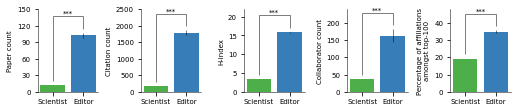

In [6]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 4*cm))

ax = plt.subplot(1, 5, 1)
plotBar(ax, [astats.APriorPaperCount.values, estats.EPriorPaperCount.values], 150)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Paper count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 30, 60, 90, 120, 150])
ax.set_ylim(0, 150)

ax = plt.subplot(1, 5, 2)
plotBar(ax, [astats.APriorCitationCount.values, estats.EPriorCitationCount.values], 2500)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Citation count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 2500)

ax = plt.subplot(1, 5, 3)
plotBar(ax, [astats.AHindex.values, estats.EHindex.values], 22)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('H-index')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 22)


ax = plt.subplot(1, 5, 4)
plotBar(ax, [astats.AColabCount.values, estats.EColabCount.values], 240)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Collaborator count')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(0, 240)


ax = plt.subplot(1, 5, 5)
plotBar(ax, [astats.ATop.values, estats.ETop.values], 0.48)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Scientist', 'Editor'])
ax.set_ylabel('Percentage of affiliations\namongst top-100')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_yticklabels([0, 10, 20, 30, 40])
ax.set_ylim(0, 0.48)

plt.tight_layout()

#plt.savefig('../figures/fig_1_abcde.pdf', bbox_inches = 'tight', pad_inches = 0)

## f, g, h, i, j, k

In [7]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), scipy.stats.sem(a), scipy.stats.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.96

In [8]:
def plot_curve(df, x, y, role, y_min, y_max, x_min, x_max, ax, window):
    df.fillna(0, inplace=True)
    meandf = pd.DataFrame()

    for year in range(x_min-window, x_max+1):
        data = df[ df[x] == year ][y].tolist()
        mid, lo, hi = mean_confidence_interval(data)
        meandf = meandf.append({x: year, 'mean': mid, 'lo': lo, 'hi': hi}, ignore_index=True)

    meandf.fillna(0, inplace=True)

    meandf['hi'] = meandf.hi.rolling(window, center=False).mean()
    meandf['lo'] = meandf.lo.rolling(window, center=False).mean()
    meandf['mean'] = meandf['mean'].rolling(window, center=False).mean()

    meandf = meandf[(meandf[x] >= x_min) & (meandf[x] <= x_max)]

    if role == 'editors':
        line, = ax.plot(meandf[x], meandf['mean'], alpha=1, color='#4daf4a', linewidth=1.2)
        ax.fill_between(meandf[x], meandf['lo'], meandf['hi'], alpha = 0.1, color='#4daf4a')
    elif role == 'authors':
        line, = ax.plot(meandf[x], meandf['mean'], alpha=1, color='#377eb8', linewidth=1.2)
        ax.fill_between(meandf[x], meandf['lo'], meandf['hi'], alpha = 0.1, color='#377eb8')
        
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])

    return line

In [9]:
def plot_dots(df, outcome, ax, style, c, x_min=1980, x_max=2017):
    for year in range(x_min, x_max+1):
        sub = df[df.Year0 == year]
        v = sub[outcome].values
        
        me, sem = meanCI(v, 0.95)
        ax.errorbar(year, me, yerr=sem, color=c, fmt=style, elinewidth=0.5, ms=2)

In [10]:
def plotTemporal(ax, a, e, ylim):
    if a is not None:
        plot_dots(astats, a, ax, 'x', '#4daf4a') # author
    plot_dots(estats, e, ax, 'o', '#377eb8')
    
    ax.set_xticks([1980,1990,2000,2010])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(b=True, ls=':')
    ax.set_ylim(0, ylim)

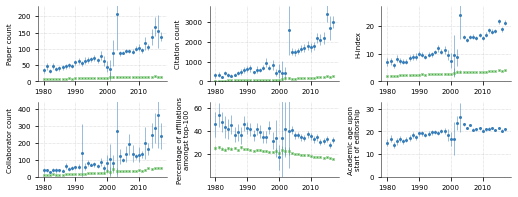

In [11]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(18.3*cm, 7*cm))

outcomes = [['APriorPaperCount','EPriorPaperCount'],
            ['APriorCitationCount','EPriorCitationCount'],
            ['AHindex','EHindex'],        
            ['AColabCount','EColabCount'],
           ['ATop','ETop']]

ylims = [230, 3800, 27, 440, 0.6, 28]

axes = [plt.subplot(2, 3, 1), plt.subplot(2, 3, 2), plt.subplot(2, 3, 3),
       plt.subplot(2, 3, 4), plt.subplot(2, 3, 5), plt.subplot(2, 3, 6)]

for i in range(5):
    plotTemporal(axes[i], *outcomes[i], ylims[i])
    
plotTemporal(axes[5], None, 'Age', ylims[5])
axes[5].set_ylim(0, 33)
# this is plotting standard error of mean, and not 95% CI !!!

axes[0].set_ylabel('Paper count')
axes[1].set_ylabel('Citation count')
axes[2].set_ylabel('H-index')
axes[3].set_ylabel('Collaborator count')
axes[4].set_ylabel('Percentage of affiliations\namongst top-100')
axes[5].set_ylabel('Academic age upon\nstart of editorship')

# top-100
axes[4].set_ylabel('Percentage of affiliations\namongst top-100')
axes[4].set_yticks([0.2, 0.4, 0.6])
axes[4].set_yticklabels(['20', '40', '60'])
axes[4].set_ylim(0, 0.65)

plt.tight_layout()

#plt.savefig('../figures/fig_1_fghijk.pdf', bbox_inches = 'tight', pad_inches = 0)

## l

In [12]:
# load field names and category of fields

field_cat = pd.DataFrame({'Field':['Psychology','Political science','Mathematics','Environmental science',
 'Computer science','Medicine','Biology','History','Physics','Geology',
 'Engineering','Philosophy','Art','Sociology','Business',
 'Economics','Chemistry','Materials science','Geography'],
'Category':['social sciences', 'social sciences', 'formal sciences', 'natural sciences', 'formal sciences', 
            'natural sciences', 'natural sciences', 'social sciences', 'natural sciences', 'natural sciences', 
            'formal sciences', 'social sciences', 'social sciences', 'social sciences', 'social sciences', 
            'social sciences', 'natural sciences', 'natural sciences', 'natural sciences']})

field_name = pd.read_csv("../data/mag/FieldsOfStudy.txt", sep="\t",
                        names = ["FieldOfStudyId", "Rank", "NormalizedName", "DisplayName",
                                 "MainType", "Level", "PaperCount", "CitationCount", "CreatedDate"],
                       usecols=['FieldOfStudyId','DisplayName']).rename(columns={'DisplayName':'Field'})

In [13]:
def fieldMean(stats):
    
    stats = getScientistField(stats)
    
    stats = stats.assign(Count=1)
    df = stats.groupby('Field').agg({'EPriorPaperCount':'mean','EPriorCitationCount':'mean',
                                     'ETop':'mean','Age':'mean','Count':sum}).sort_values(
        by='Count', ascending=False).reset_index().head(16)
    
    return df

def getScientistField(df):
    df = df.merge(field_name, on='FieldOfStudyId')
    df = df.merge(field_cat, on='Field')
    print(df.shape)
    
    return df

In [14]:
df = fieldMean(estats.rename(columns={'Parent':'FieldOfStudyId'}))

(19107, 10)


In [15]:
df

,Field,EPriorPaperCount,EPriorCitationCount,ETop,Age,Count
0,Biology,142.832119,2915.671005,0.330557,22.458355,3842
1,Economics,54.556069,1105.845954,0.375723,18.595087,3460
2,Computer science,120.537748,2007.431788,0.324503,19.156291,2265
3,Physics,136.490775,1679.795203,0.381919,23.744157,1626
4,Mathematics,90.623161,1235.389635,0.404990,21.712732,1563
5,Medicine,96.059406,2054.980198,0.395278,20.239909,1313
6,Chemistry,148.949066,2311.984720,0.308149,22.915959,1178
7,Psychology,71.172448,1750.674926,0.301288,19.267592,1009
8,Political science,50.784288,656.049268,0.320905,18.006658,751
9,Engineering,100.255782,865.360544,0.322449,19.978231,735


In [16]:
cmap = LinearSegmentedColormap.from_list("", [(0, 'grey'),(0.2, 'dodgerblue'),(0.4, 'green'),(0.6, 'gold'),(1,"red")])
MIN, MAX = df.ETop.min(), df.ETop.max()
LEN=MAX-MIN

toColor = lambda x: cmap((x-MIN)/LEN)
calcSize= lambda x: (x-15)**2*12+80

df = df.assign(markerolor=df.ETop.apply(toColor))   
df = df.assign(markersize=df.Age.apply(calcSize))

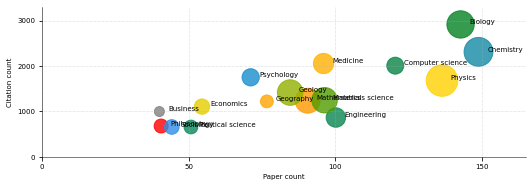

In [17]:
plt.figure(figsize=(22*cm, 7*cm))

ax = plt.gca()
ax.set_xlim(0, 165)
ax.set_ylim(0, 3300)

ax.set_yticks([0, 1000, 2000, 3000])
ax.set_xticks([0, 50, 100, 150])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, ls=':')
ax.set_xlabel('Paper count')
ax.set_ylabel('Citation count')

plt.scatter(x=df.EPriorPaperCount, y=df.EPriorCitationCount, s=df.markersize, c = df.markerolor, alpha=0.8)

for ind, row in df.iterrows():
    ax.annotate(row['Field'], (row['EPriorPaperCount']+3, row['EPriorCitationCount']+10))

#plt.savefig('../figures/fig_1_l.pdf', bbox_inches = 'tight', pad_inches = 0)

In [18]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.figure(figsize=(8*cm, 0.1*cm))
ax = plt.gca()
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

ticks = [0.25, 0.3, 0.35, 0.4, 0.45]
pos = [(x-MIN)/LEN*256 for x in ticks]

ax.set_xticks(pos)
ax.set_xticklabels([int(x*100) for x in ticks])

[Text(1.5015897379673229, 0, '25'),
 Text(60.06358951869311, 0, '30'),
 Text(118.62558929941889, 0, '35'),
 Text(177.18758908014476, 0, '40'),
 Text(235.74958886087055, 0, '45')]

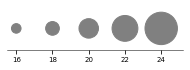

In [19]:
plt.figure(figsize=(8*cm, 2*cm))
ax = plt.gca()

xs=[16, 18, 20, 22, 24]
ax.set_xlim(15.5, 25.2)
ax.set_xticks([16, 18, 20, 22, 24])
ax.set_ylim(0, 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])

ax.scatter(xs, [1, 1, 1, 1, 1], s=[calcSize(x) for x in xs], c='gray')